# Synthetic Data Generation

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import matplotlib.pyplot as plt

from src import Flag, AbstractTask, AbstractFlag, Pipeline
import numpy as np

from matplotlib.ticker import PercentFormatter
from src import PlotPipelineFactory
import warnings
warnings.filterwarnings("ignore")

In [2]:
dataPath = r"../data/csv/"
picklePath = r"../pickle_objects/modeling_pipeline/"
plotPath = r"../plots/inference/"
modelPath = r"../pickle_objects/models_and_scalers/"

In [3]:
import pickle
with open(picklePath + 'Modeling Pipeline.pickle', 'rb') as f:
    ModelingPipeline = pickle.load(f)

ModelingPipeline.print(priority = True, flags = True)

Modeling Pipeline
	10 Pre Processing: Pre Processing
		10 Select and order columns
		20 Company ID and UUID
			10 Fill Company ID with None
			20 Fill UUID with None
			30 Replace Company IDs
			40 Replace Company UUIDs
		30 MS Data Processing
			10 Fill MS Data with empty String
			20 Length of MS Data
			30 Continuity Type
			40 Drop MS Data Column
		40 Service Data Processing
			10 Fill Service Data with empty String
			20 Length of Service Data
			30 Samsung Type
			40 Drop Service Data Column
		50 Fill Numeric NA with 0
		60 Fill String NA with None
		70 Datetime conversion
		80 Clean PDU
		90 Order DataFrame
		100 Convert object type to string
	20 Dummy Processing: Dummy Processing
		10 Dummies Channel
		20 Dummies AD Type
		30 Dummies Company
		40 Dummies UUID
		50 Dummies PDU Type
		60 Dummies Continuity Type
		70 Dummies SmartTag Type
	30 Labeling: Labeling
		10 Labeling auto: Labeling auto
			Label FindMy Tracker and iDevice: Label FindMy Tracker and iDevice
			Label Tile and

In [4]:
with open(picklePath + 'Pre Processing.pickle', 'rb') as f:
    flag_preProcessing = pickle.load(f)

with open(picklePath +  'Modeling.pickle', 'rb') as f:
    flag_modeling = pickle.load(f)

with open(picklePath + 'Dummy Processing.pickle', 'rb') as f:
    flag_dummy= pickle.load(f)

with open(picklePath + 'Rate Modeling.pickle', 'rb') as f:
    flag_Rate_Modeling = pickle.load(f)

In [5]:
def filesToDataFrame(filesDict: dict[str:AbstractFlag], filePath:str = dataPath, config:AbstractTask = ModelingPipeline) -> pd.DataFrame:
    dataset = pd.DataFrame()

    for f in filesDict.keys():
        new_dataset = Pipeline().setPath(filePath + f).setTask(config).loadData().run(flag=filesDict[f])
        dataset = pd.concat([dataset, new_dataset])
        
    dataset.reset_index(drop = True, inplace = True)

    return dataset

def Inference(dataset: pd.DataFrame, modelName: str, scalerName: str, path:str = modelPath):
    with open(path + modelName + ".pickle", 'rb') as f:
        model = pickle.load(f)

    with (open(path + scalerName + ".pickle", 'rb') as f):
        scaler = pickle.load(f)
        
    sourceData = dataset[['Source','Time']]
    dataset = dataset.drop(columns=['Source','Time'], axis = 1)

    X_scaled = scaler.transform(dataset.copy(deep=True).to_numpy())
    
    y_pred = model.predict_proba(X_scaled)
    y_pred = pd.DataFrame(data=y_pred, columns=model.classes_)
    
    y_pred = y_pred.round(4) * 100
    y_pred = pd.concat([sourceData, y_pred], axis=1)
    y_pred['Label'] = model.predict(X_scaled)
    y_pred['Label'] = y_pred['Label'].astype("string")

    y_pred['Max Proba'] = y_pred.iloc[:, 2:-1].max(axis = 1)
    
    return y_pred, list(model.classes_)

In [6]:
Modeling_Flag = Flag("Modeling", parents=[flag_modeling, flag_dummy, flag_preProcessing])

files = {"Inference/Bahnhof_V1.csv": Modeling_Flag,
         }

data = filesToDataFrame(files)

y_pred, labels = Inference(data, modelName = "Neural Network model", scalerName="Neural Network scaler")

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97990 entries, 0 to 97989
Data columns (total 31 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Time                                        97990 non-null  datetime64[ns]
 1   Source                                      97990 non-null  string        
 2   Length Packet                               97990 non-null  int64         
 3   Length Header                               97990 non-null  int64         
 4   Length MS Data                              97990 non-null  int64         
 5   Length Service Data                         97990 non-null  int64         
 6   CH 37                                       97990 non-null  int64         
 7   CH 38                                       97990 non-null  int64         
 8   CH 39                                       97990 non-null  int64         
 9   AD Man

In [8]:
y_pred.head()

,Source,Time,FindMy Tracker (lost),FindMy Tracker (nearby),FindMy Tracker (unpaired),SmartTag (lost),SmartTag (nearby),Tile (lost),iDevice,iDevice FindMy offline,iDevice FindMy online,other Device,Label,Max Proba
0,72:bd:26:15:e5:43,2024-04-25 15:04:30.115560055,0.0,0.00,0.00,0.0,0.0,0.00,100.00,0.00,0.00,0.00,iDevice,100.00
1,58:6e:60:f8:8b:b2,2024-04-25 15:04:30.115560055,0.0,0.00,0.00,0.0,0.0,0.00,100.00,0.00,0.00,0.00,iDevice,100.00
2,58:6e:60:f8:8b:b2,2024-04-25 15:04:30.117041111,0.0,0.00,0.00,0.0,0.0,0.00,100.00,0.00,0.00,0.00,iDevice,100.00
3,58:6e:60:f8:8b:b2,2024-04-25 15:04:30.118024111,0.0,0.00,0.00,0.0,0.0,0.00,100.00,0.00,0.00,0.00,iDevice,100.00
4,57:77:6e:a6:b3:df,2024-04-25 15:04:30.119189978,0.0,0.03,0.02,0.0,37.0,0.02,0.05,0.01,0.01,62.86,other Device,62.86


In [9]:
# Not saving the plot @Keisuke

def plotLorenz(dataToPlot):
    title_suffix = str(dataToPlot['Label'].iloc[0])
    title = 'Confidence - ' + title_suffix

    dataToPlot = dataToPlot.sort_values(by = 'Max Proba', ascending = False)
    dataToPlot['Percentile'] = np.arange(0, dataToPlot.shape[0]) / (dataToPlot.shape[0] - 1)

    plt.figure(figsize = (16, 9), dpi = 100)
    plt.plot(dataToPlot['Percentile'], dataToPlot['Max Proba'] / 100)
    plt.xlim(0)
    plt.ylim(bottom = 0, top = 1.1)
    plt.title(title, fontsize = 20)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
  
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.ylabel("Confidence", fontsize = 15)
    plt.xlabel("% of Packets", fontsize = 15)
    plt.tight_layout()
    #plt.savefig(plotPath + "confidence" + "\\" + title + '.png', dpi = 300)
    plt.show()

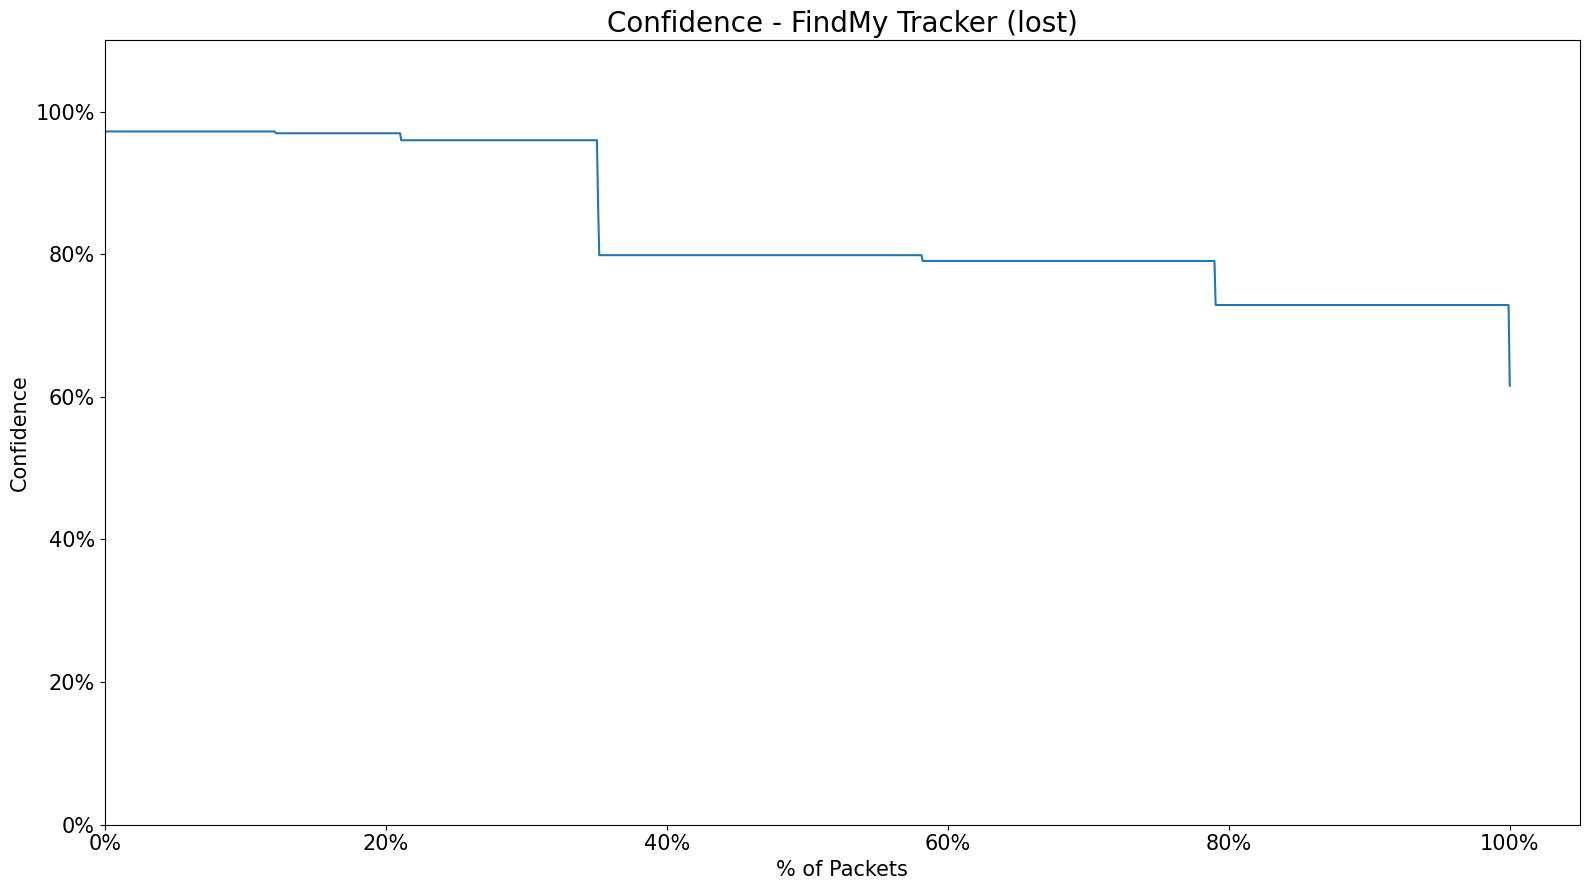

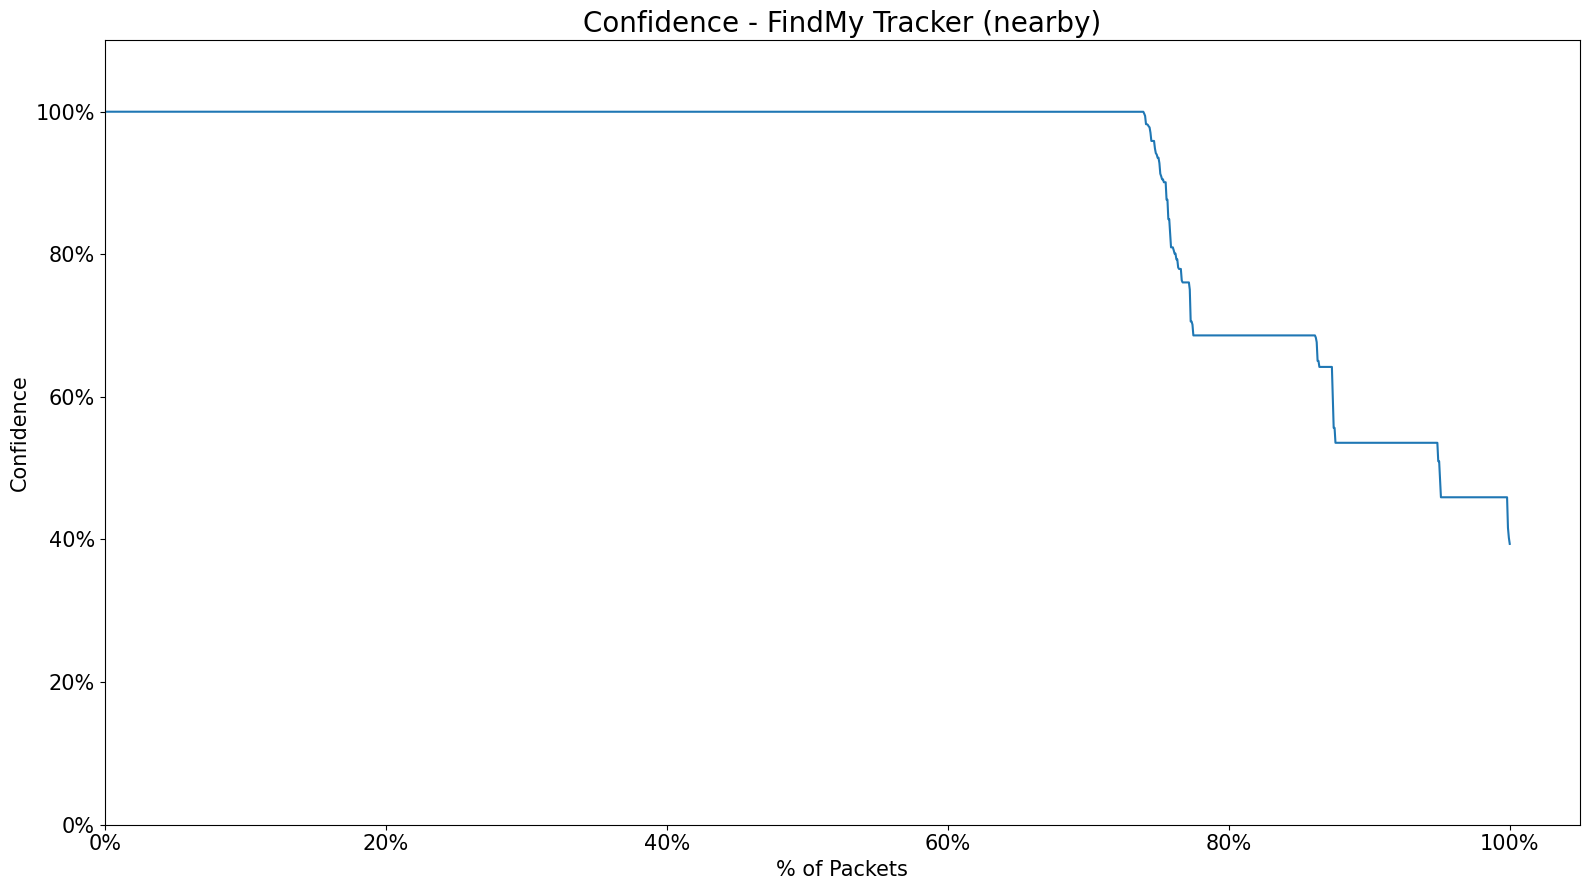

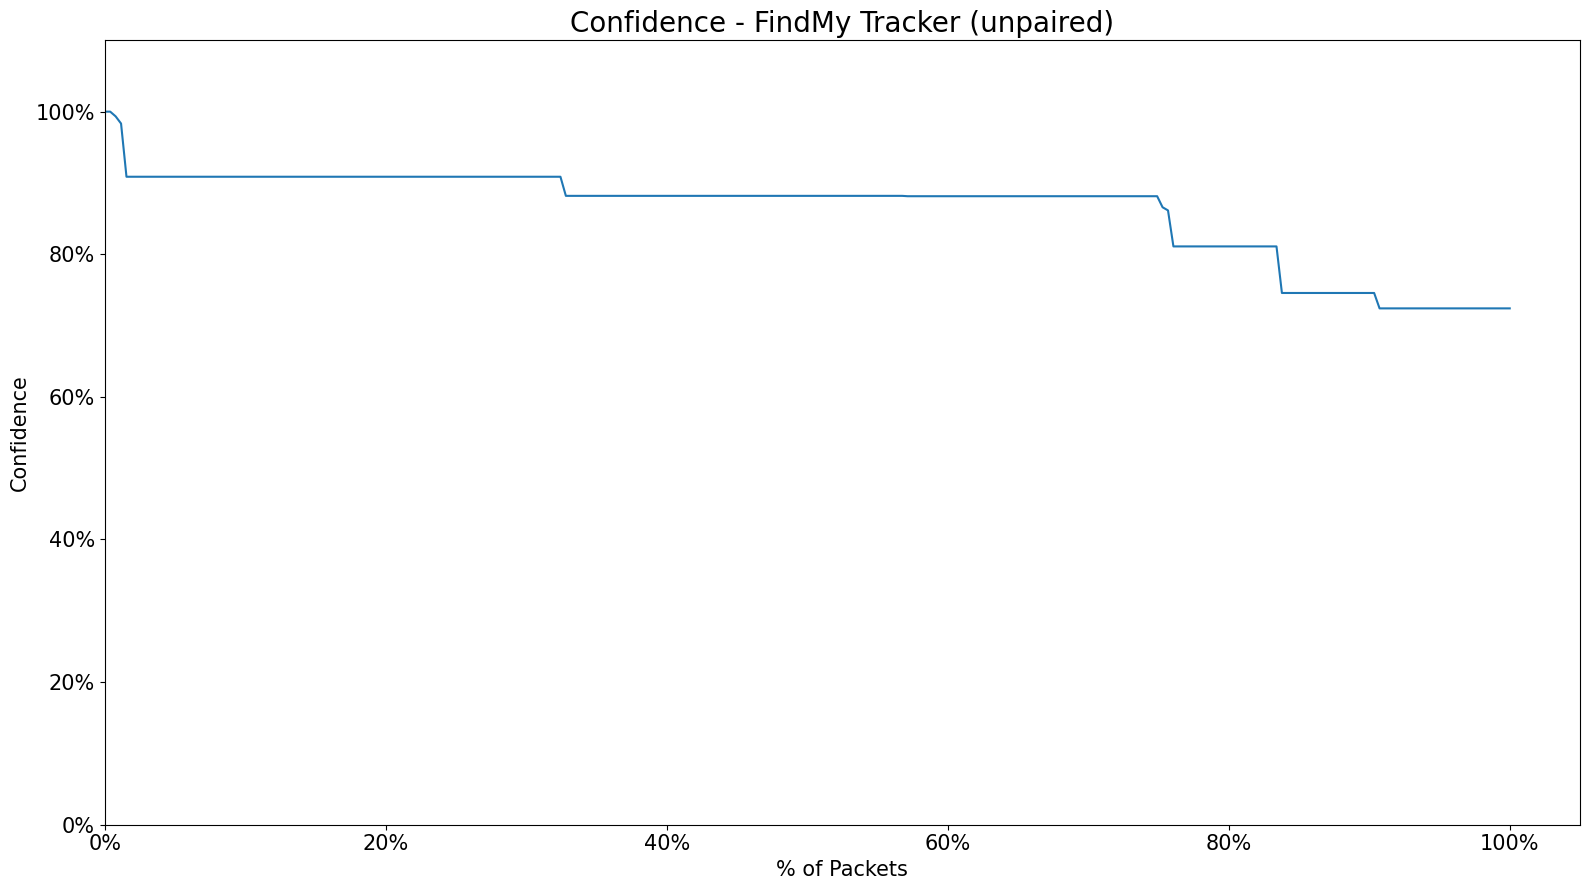

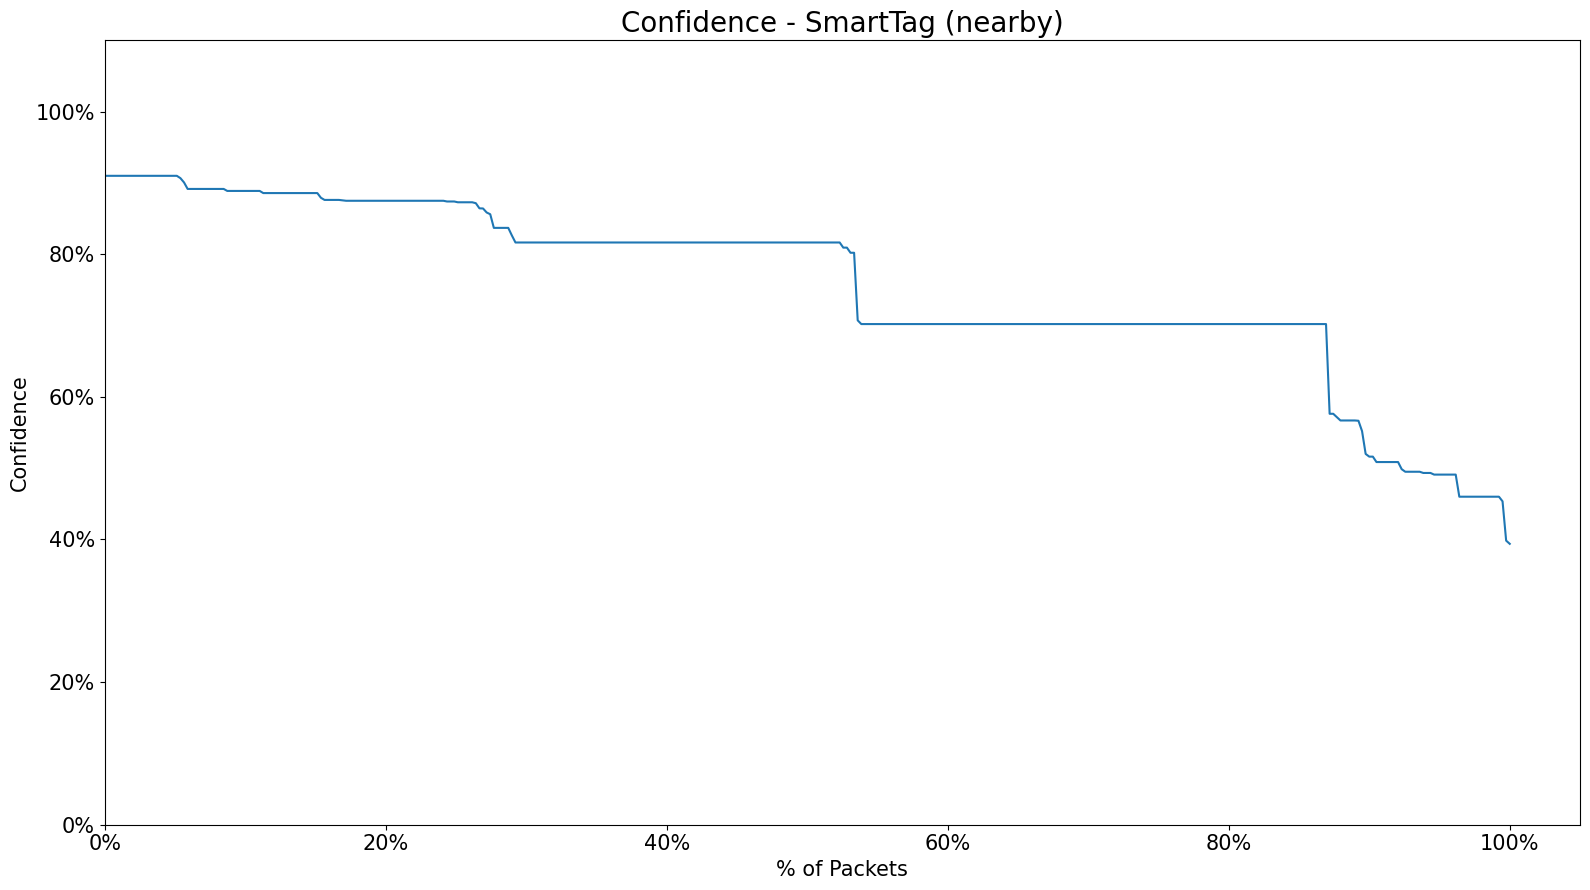

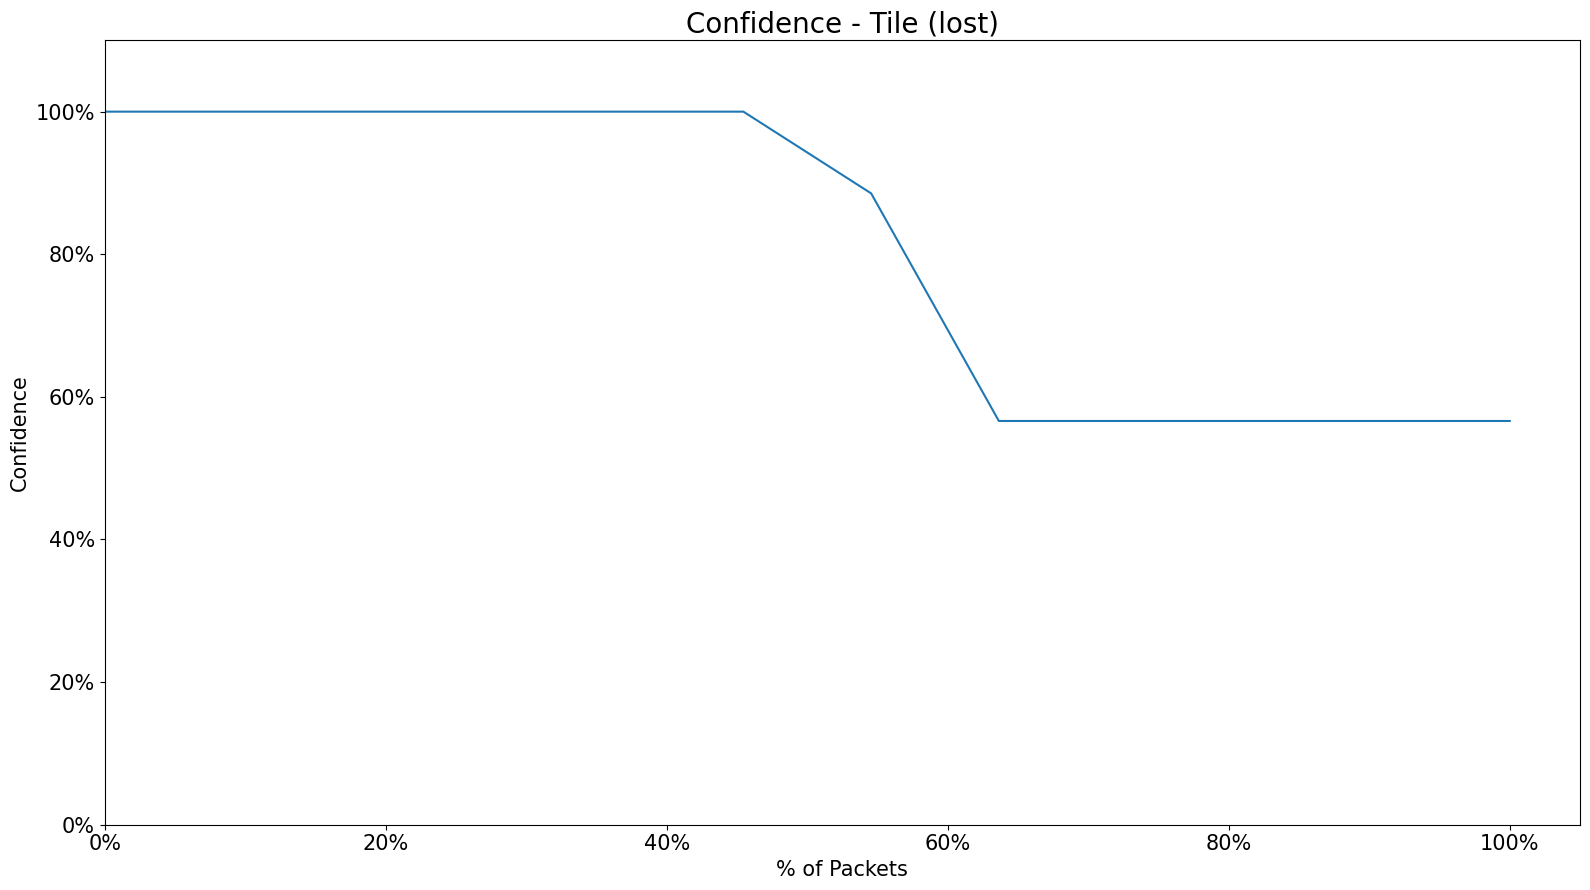

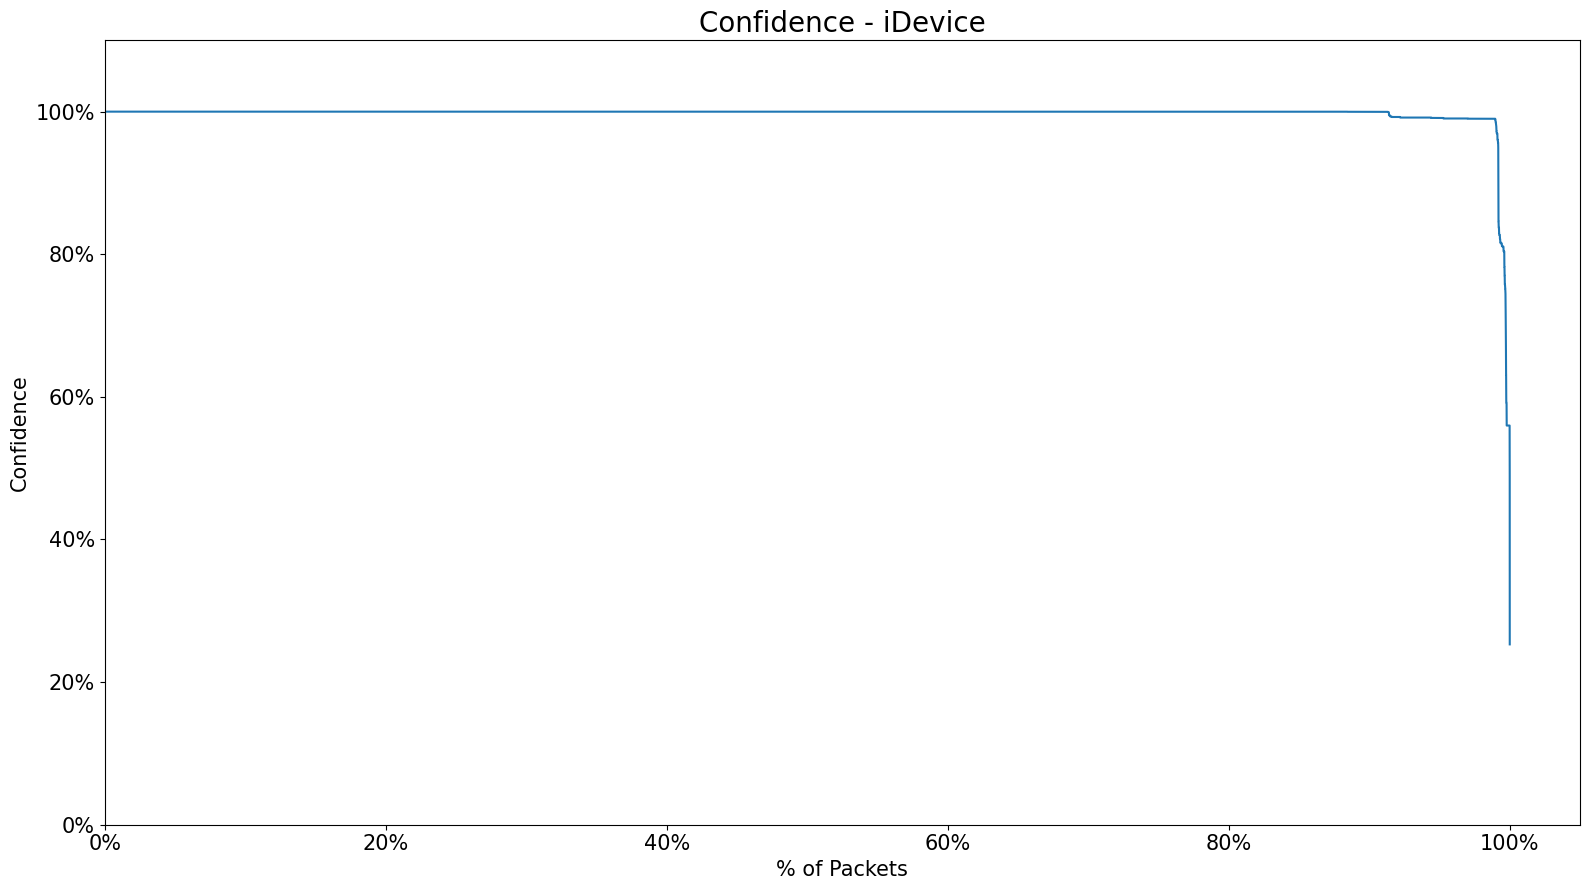

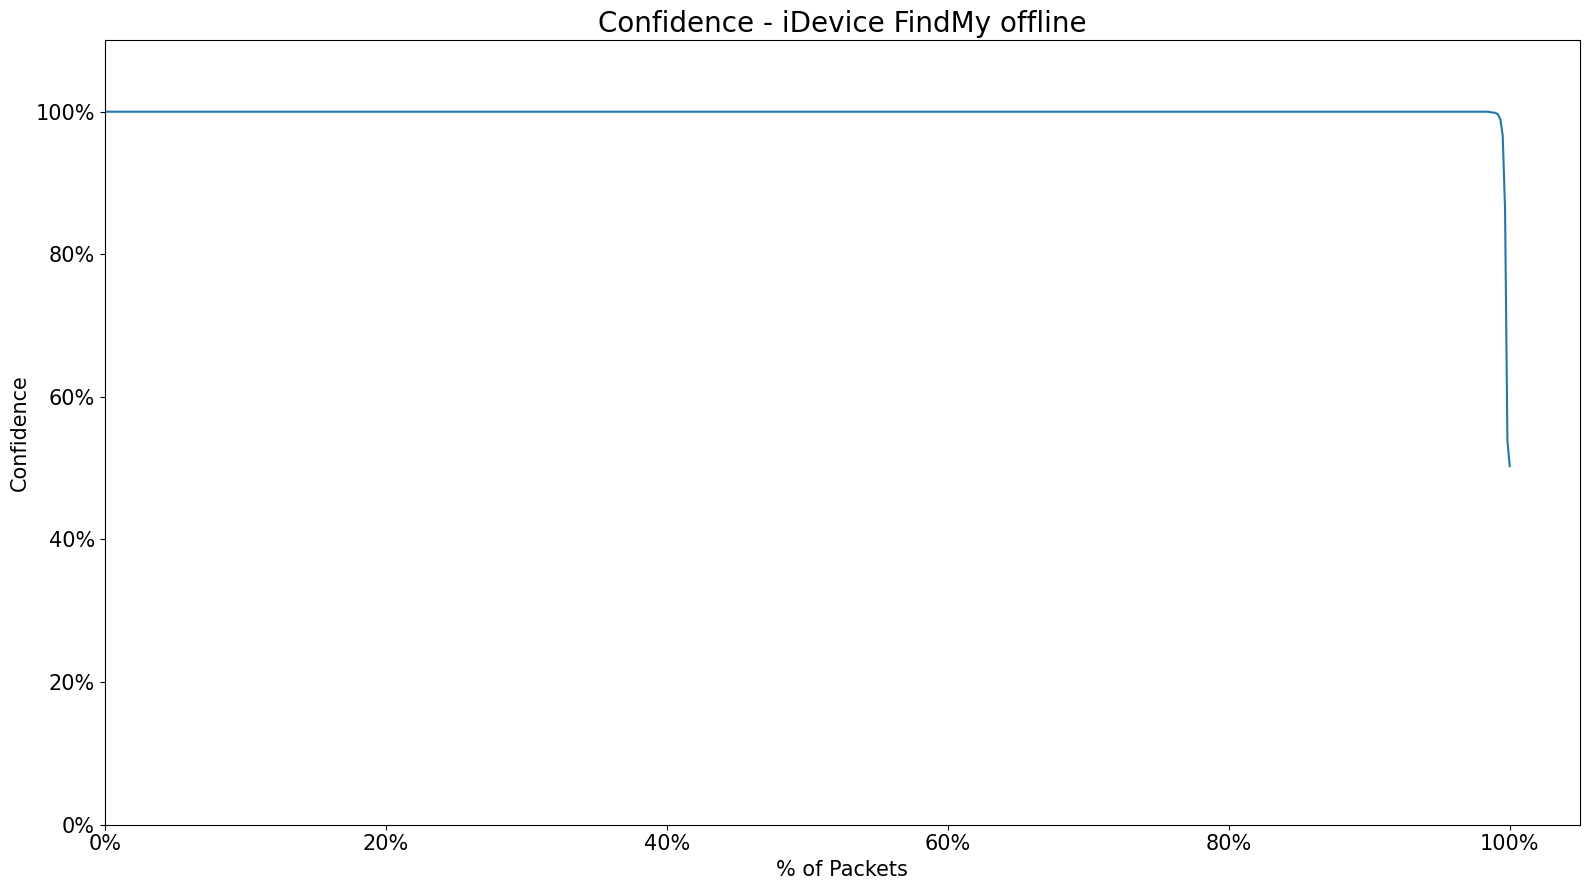

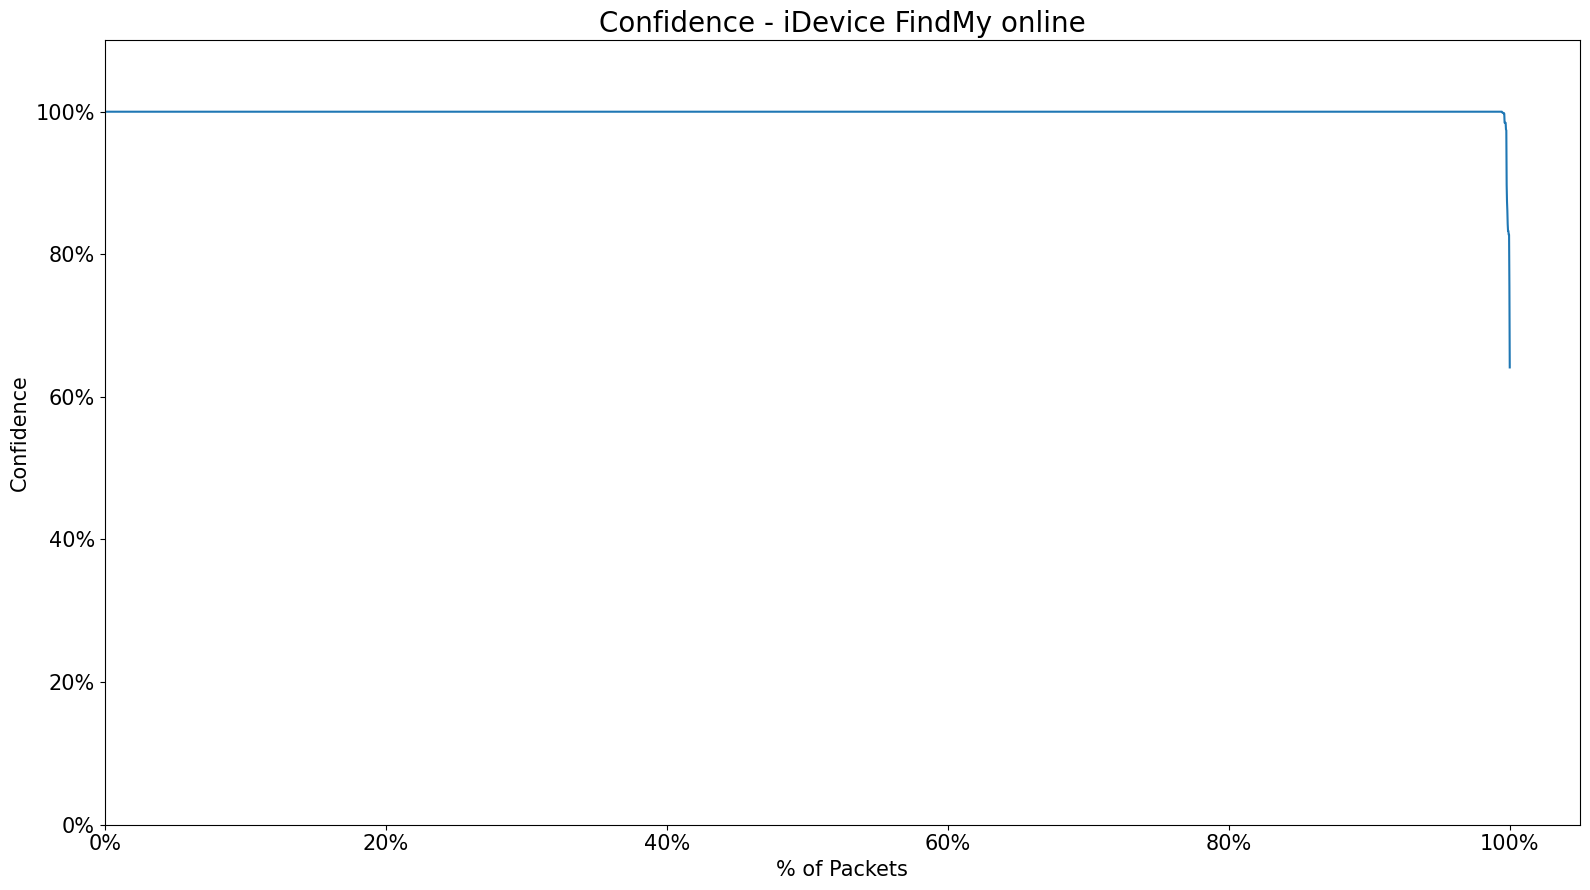

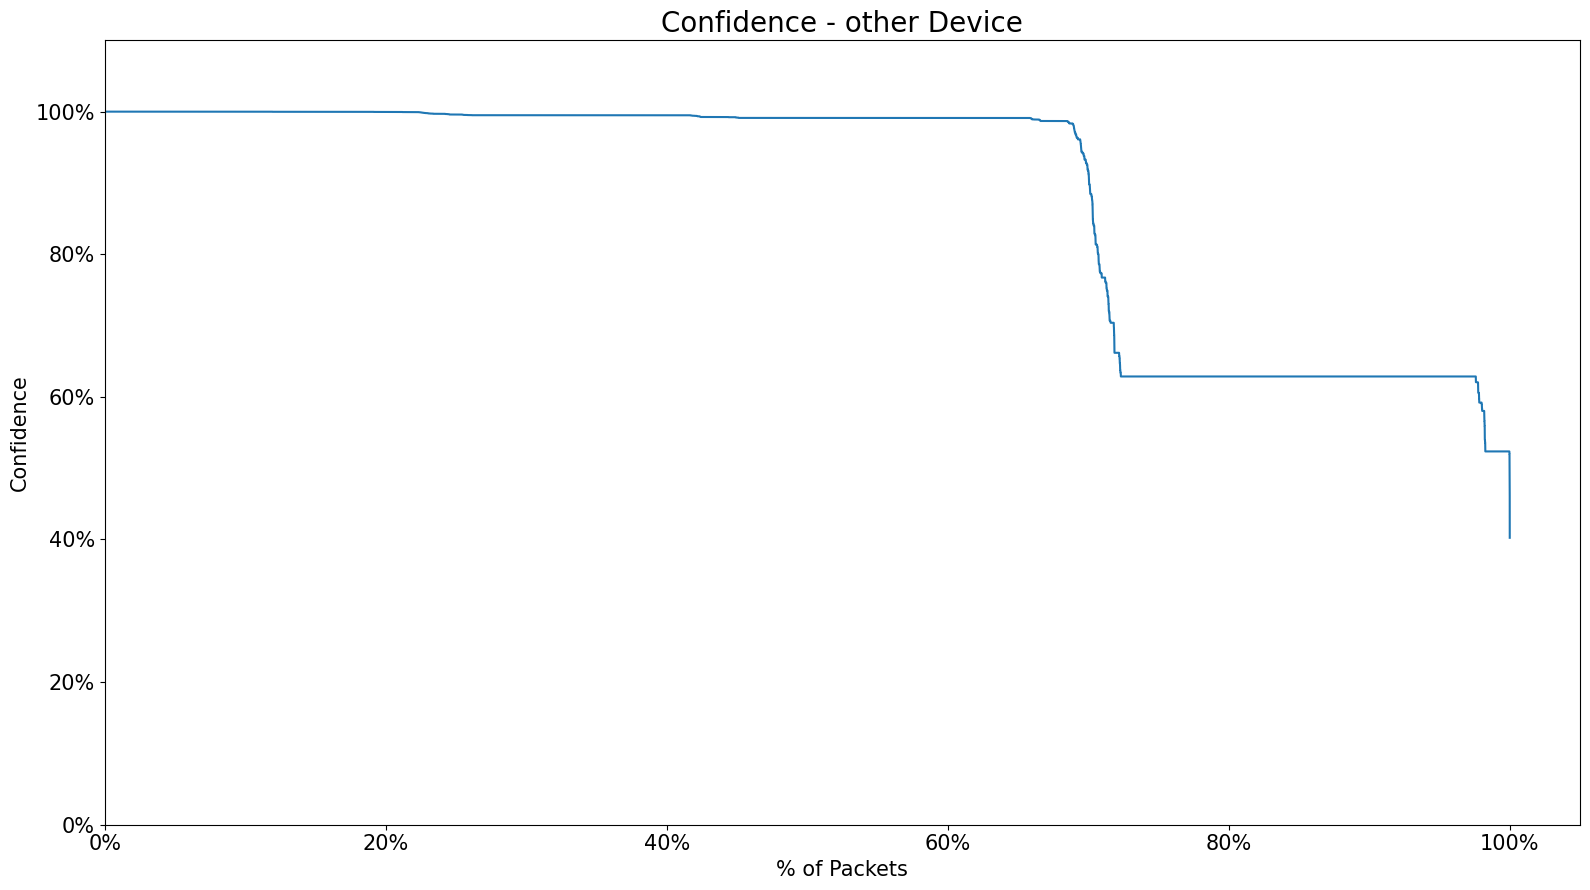

""


In [10]:
y_pred.groupby('Label').apply(plotLorenz)

In [11]:
y_pred

,Source,Time,FindMy Tracker (lost),FindMy Tracker (nearby),FindMy Tracker (unpaired),SmartTag (lost),SmartTag (nearby),Tile (lost),iDevice,iDevice FindMy offline,iDevice FindMy online,other Device,Label,Max Proba
0,72:bd:26:15:e5:43,2024-04-25 15:04:30.115560055,0.0,0.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,iDevice,100.00
1,58:6e:60:f8:8b:b2,2024-04-25 15:04:30.115560055,0.0,0.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,iDevice,100.00
2,58:6e:60:f8:8b:b2,2024-04-25 15:04:30.117041111,0.0,0.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,iDevice,100.00
3,58:6e:60:f8:8b:b2,2024-04-25 15:04:30.118024111,0.0,0.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,iDevice,100.00
4,57:77:6e:a6:b3:df,2024-04-25 15:04:30.119189978,0.0,0.03,0.02,0.00,37.00,0.02,0.05,0.01,0.01,62.86,other Device,62.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97985,78:a6:72:61:ca:f8,2024-04-25 15:14:32.456671953,0.0,0.03,0.02,0.00,37.00,0.02,0.05,0.01,0.01,62.86,other Device,62.86
97986,4c:43:00:86:e9:cb,2024-04-25 15:14:32.480820894,0.0,0.01,0.00,0.01,0.01,0.01,0.03,0.00,0.00,99.93,other Device,99.93
97987,6a:ee:d9:d3:35:62,2024-04-25 15:14:32.494939089,0.0,0.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,iDevice,100.00
97988,42:39:98:6f:b4:6f,2024-04-25 15:14:32.498136044,0.0,0.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,iDevice,100.00


In [12]:
temp = y_pred.copy(deep = True)

In [13]:
temp = temp.groupby(['Source', 'Label']).agg(Count = ('Label', 'count'), Probability = ('Max Proba', 'mean')).reset_index()

temp['Score'] = temp['Count'] * temp['Probability']
temp['Score'] = 100 *  temp['Score'] / temp.groupby(['Source'])['Score'].transform('sum')
temp = temp.round(2)
temp

,Source,Label,Count,Probability,Score
0,00:09:a7:5a:93:16,other Device,7,100.00,100.00
1,00:1b:66:c0:1d:42,Tile (lost),5,56.62,30.37
2,00:1b:66:c0:1d:42,other Device,10,64.91,69.63
3,01:02:00:4b:d3:17,other Device,1,99.16,100.00
4,01:02:48:42:2b:e5,other Device,1,99.98,100.00
...,...,...,...,...,...
5243,ff:8a:80:f9:ce:91,other Device,1,100.00,100.00
5244,ff:a5:6c:ba:8a:31,iDevice FindMy online,10,99.99,100.00
5245,ff:d4:21:80:72:3f,iDevice FindMy online,2,99.99,100.00
5246,ff:d7:3f:79:d3:62,iDevice FindMy offline,1,99.99,100.00


In [14]:
devices = temp.loc[temp.groupby(['Source'])['Score'].idxmax()]
devices

,Source,Label,Count,Probability,Score
0,00:09:a7:5a:93:16,other Device,7,100.00,100.00
2,00:1b:66:c0:1d:42,other Device,10,64.91,69.63
3,01:02:00:4b:d3:17,other Device,1,99.16,100.00
4,01:02:48:42:2b:e5,other Device,1,99.98,100.00
5,01:02:4b:ea:71:34,other Device,1,99.56,100.00
...,...,...,...,...,...
5243,ff:8a:80:f9:ce:91,other Device,1,100.00,100.00
5244,ff:a5:6c:ba:8a:31,iDevice FindMy online,10,99.99,100.00
5245,ff:d4:21:80:72:3f,iDevice FindMy online,2,99.99,100.00
5246,ff:d7:3f:79:d3:62,iDevice FindMy offline,1,99.99,100.00


In [15]:
threshold = 0
devices = devices[devices['Probability'] > threshold]

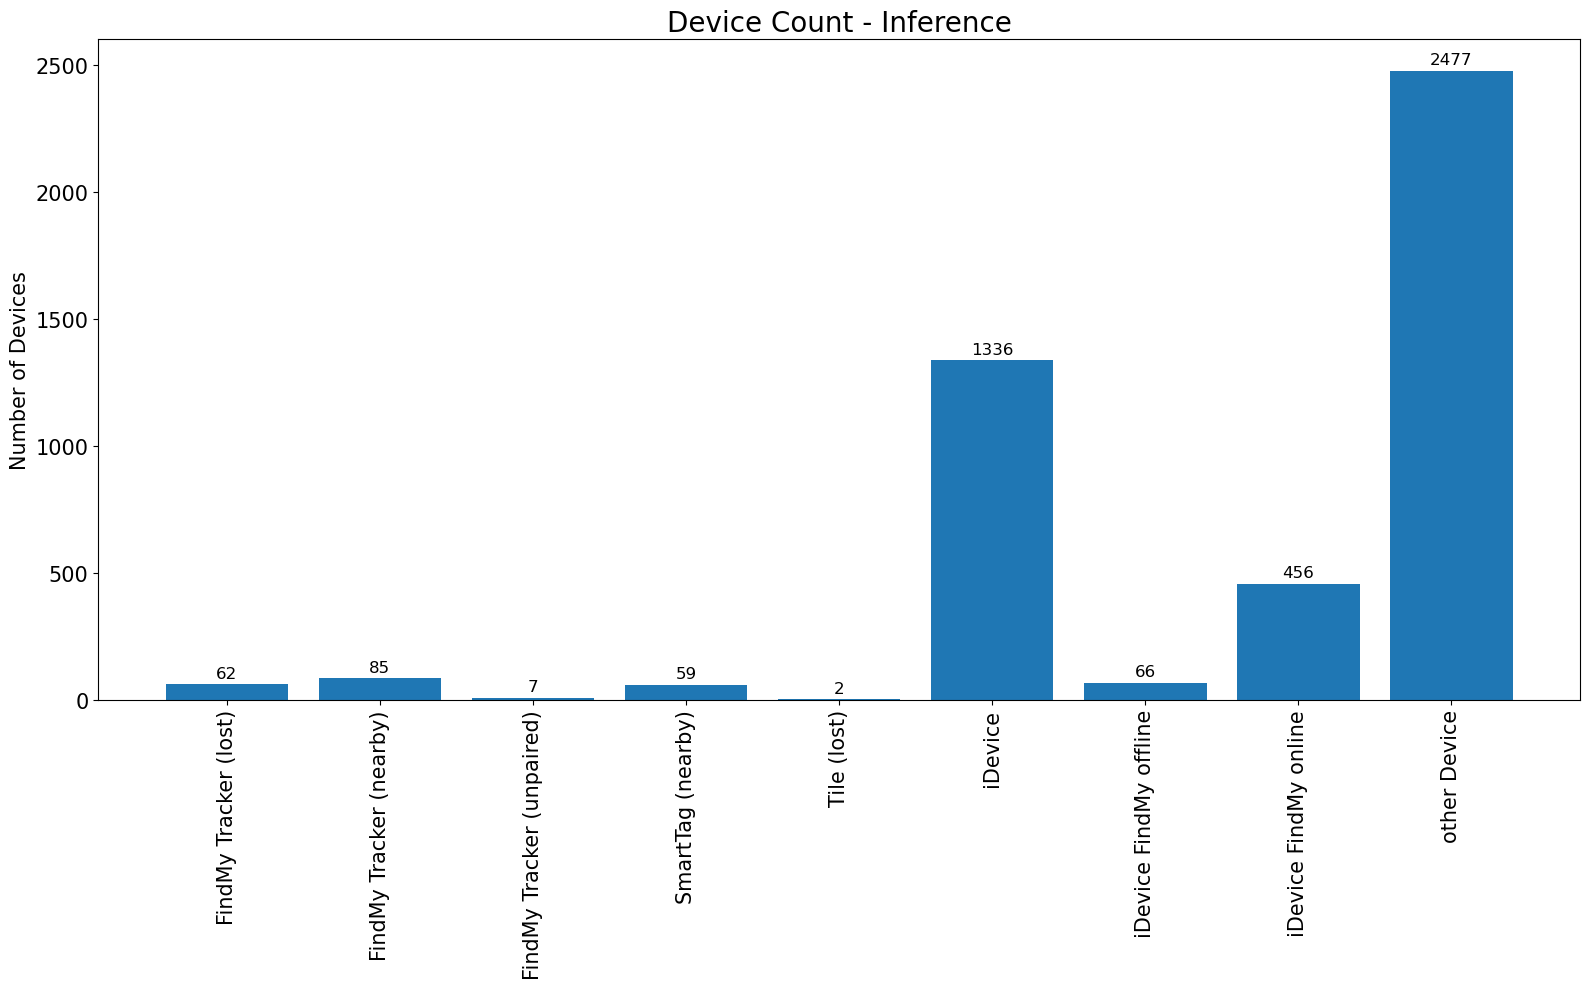

In [16]:
# Not saving the plot @Keisuke

deviceCounts = devices.groupby('Label').size().reset_index().rename(columns = {0:'Count'})

x = deviceCounts['Label']
y = deviceCounts['Count']

title = "Device Count - Inference"
plt.figure(figsize=(16, 10), dpi = 100),
plt.bar(x, y)

offset = y.max() * 0.01
for i in range(len(x)):
    plt.text(i, y[i] + offset, np.round(y[i]), ha='center', fontsize = 12)

plt.ylabel("Number of Devices", fontsize=15)
plt.xticks(rotation = 90, fontsize=15)
plt.yticks(fontsize=15)
plt.title(title, fontsize = 20)
plt.tight_layout()
#plt.savefig(plotPath + title + '.png', dpi = 300)
plt.show()

In [17]:
print(round(devices['Source'].nunique() * 100 / y_pred['Source'].nunique(),1),"%")

100.0 %


In [18]:
print(round(len(y_pred.merge(devices, on = ['Source'], how = 'inner')) / len(y_pred) * 100,1), '%')

100.0 %


In [19]:
devices

,Source,Label,Count,Probability,Score
0,00:09:a7:5a:93:16,other Device,7,100.00,100.00
2,00:1b:66:c0:1d:42,other Device,10,64.91,69.63
3,01:02:00:4b:d3:17,other Device,1,99.16,100.00
4,01:02:48:42:2b:e5,other Device,1,99.98,100.00
5,01:02:4b:ea:71:34,other Device,1,99.56,100.00
...,...,...,...,...,...
5243,ff:8a:80:f9:ce:91,other Device,1,100.00,100.00
5244,ff:a5:6c:ba:8a:31,iDevice FindMy online,10,99.99,100.00
5245,ff:d4:21:80:72:3f,iDevice FindMy online,2,99.99,100.00
5246,ff:d7:3f:79:d3:62,iDevice FindMy offline,1,99.99,100.00


In [20]:
tracker = 'SmartTag (nearby)'
sources = y_pred[y_pred['Label'] == tracker]
sources['Source'].unique()
sources.reset_index(inplace=True, drop=True)
sources = sources.drop_duplicates()
sources

,Source,Time,FindMy Tracker (lost),FindMy Tracker (nearby),FindMy Tracker (unpaired),SmartTag (lost),SmartTag (nearby),Tile (lost),iDevice,iDevice FindMy offline,iDevice FindMy online,other Device,Label,Max Proba
0,4c:d6:22:22:c9:d1,2024-04-25 15:04:30.166889906,0.03,4.44,0.52,0.03,91.00,0.16,0.15,0.00,0.00,3.68,SmartTag (nearby),91.00
1,4c:d6:22:22:c9:d1,2024-04-25 15:04:30.222747087,0.03,4.44,0.52,0.03,91.00,0.16,0.15,0.00,0.00,3.68,SmartTag (nearby),91.00
2,None,2024-04-25 15:04:30.298043966,0.00,0.05,0.02,0.00,50.86,0.02,0.06,0.01,0.03,48.94,SmartTag (nearby),50.86
3,6f:a9:fa:78:63:36,2024-04-25 15:04:30.316032887,0.05,7.36,0.46,0.05,87.50,0.36,0.15,0.00,0.00,4.07,SmartTag (nearby),87.50
4,4c:d6:22:22:c9:d1,2024-04-25 15:04:30.605292082,0.03,4.44,0.52,0.03,91.00,0.16,0.15,0.00,0.00,3.68,SmartTag (nearby),91.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,a0:9e:1a:b3:e6:8b,2024-04-25 15:14:20.858103037,0.01,2.80,0.55,0.01,52.00,0.00,0.32,0.00,0.00,44.31,SmartTag (nearby),52.00
387,58:0e:73:0d:2b:79,2024-04-25 15:14:24.664510012,0.05,2.08,0.73,0.03,88.58,0.19,0.20,0.00,0.00,8.14,SmartTag (nearby),88.58
388,68:37:3b:16:ce:3e,2024-04-25 15:14:26.377909899,0.04,0.34,0.66,0.05,56.69,0.72,34.44,0.00,0.00,7.07,SmartTag (nearby),56.69
389,6a:e6:d9:d3:35:62,2024-04-25 15:14:26.987545967,0.00,0.29,0.15,0.03,80.21,0.00,0.01,0.00,0.00,19.31,SmartTag (nearby),80.21


In [21]:
sources = devices[devices['Label'] == tracker][['Source']]
original_data = pd.read_csv(dataPath + r"Inference/Bahnhof_V1.csv", encoding='cp1252')

In [22]:
original_data

,Number,Time Delta,Time,Source,Destination,Protocol,Channel,Length Packet,Length Header,AD Type,Company ID,MS Data,UUID,Service Data,PDU
0,1,0.000000,1.714057e+09,72:bd:26:15:e5:43,ff:ff:ff:ff:ff:ff,LE LL,37,49,23,"Flags,Tx Power Level,Manufacturer Specific","Apple, Inc.",100506184015bf,NaN,NaN,ADV_IND
1,2,0.000000,1.714057e+09,58:6e:60:f8:8b:b2,ff:ff:ff:ff:ff:ff,LE LL,38,49,23,"Flags,Tx Power Level,Manufacturer Specific","Apple, Inc.",10052d18f2fd9b,NaN,NaN,ADV_IND
2,3,0.001481,1.714057e+09,58:6e:60:f8:8b:b2,ff:ff:ff:ff:ff:ff,LE LL,39,49,23,"Flags,Tx Power Level,Manufacturer Specific","Apple, Inc.",10052d18f2fd9b,NaN,NaN,ADV_IND
3,4,0.002464,1.714057e+09,58:6e:60:f8:8b:b2,ff:ff:ff:ff:ff:ff,LE LL,37,49,23,"Flags,Tx Power Level,Manufacturer Specific","Apple, Inc.",10052d18f2fd9b,NaN,NaN,ADV_IND
4,5,0.003630,1.714057e+09,57:77:6e:a6:b3:df,58:6e:60:f8:8b:b2,LE LL,37,38,12,NaN,NaN,NaN,NaN,NaN,SCAN_REQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97985,97986,602.341112,1.714058e+09,78:a6:72:61:ca:f8,78:20:ee:cb:d8:29,LE LL,37,38,12,NaN,NaN,NaN,NaN,NaN,SCAN_REQ
97986,97987,602.365261,1.714058e+09,4c:43:00:86:e9:cb,ff:ff:ff:ff:ff:ff,LE LL,39,50,24,"Tx Power Level,Service Data - 16 bit UUID,16-b...",NaN,NaN,"Google,Sony Corporation",00300000001145,ADV_IND
97987,97988,602.379379,1.714058e+09,6a:ee:d9:d3:35:62,ff:ff:ff:ff:ff:ff,LE LL,39,51,25,"Flags,Tx Power Level,Manufacturer Specific","Apple, Inc.",1007341f1319db6f18,NaN,NaN,ADV_IND
97988,97989,602.382576,1.714058e+09,42:39:98:6f:b4:6f,ff:ff:ff:ff:ff:ff,LE LL,38,46,20,"Flags,Tx Power Level,Manufacturer Specific","Apple, Inc.",10022100,NaN,NaN,ADV_IND


In [23]:
SmartTagData = original_data.merge(sources, on = ['Source'], how = 'inner')
SmartTagData = SmartTagData.sort_values(by = 'UUID', ascending = True)
SmartTagData = SmartTagData.reset_index(drop = True)
SmartTagData = SmartTagData[~SmartTagData['UUID'].str.contains('Samsung', na=False)]

In [24]:
SmartTagData

,Number,Time Delta,Time,Source,Destination,Protocol,Channel,Length Packet,Length Header,AD Type,Company ID,MS Data,UUID,Service Data,PDU
0,97366,596.871986,1.714058e+09,6a:e6:d9:d3:35:62,ff:ff:ff:ff:ff:ff,LE LL,37,51,25,"Flags,16-bit Service Class UUIDs (incomplete),...",NaN,NaN,0x0c2c,NaN,ADV_IND[Malformed Packet]
2,66641,399.452170,1.714058e+09,80:c3:ba:47:3a:8b,ff:ff:ff:ff:ff:ff,LE LL,39,49,23,"Flags,16-bit Service Class UUIDs (incomplete),...",NaN,NaN,Sennheiser Consumer Audio GmbH,NaN,ADV_IND
3,63562,378.549317,1.714058e+09,80:c3:ba:47:3a:8b,ff:ff:ff:ff:ff:ff,LE LL,39,49,23,"Flags,16-bit Service Class UUIDs (incomplete),...",NaN,NaN,Sennheiser Consumer Audio GmbH,NaN,ADV_IND
4,63558,378.547473,1.714058e+09,80:c3:ba:47:3a:8b,ff:ff:ff:ff:ff:ff,LE LL,37,49,23,"Flags,16-bit Service Class UUIDs (incomplete),...",NaN,NaN,Sennheiser Consumer Audio GmbH,NaN,ADV_IND
5,63501,378.134599,1.714058e+09,80:c3:ba:47:3a:8b,ff:ff:ff:ff:ff:ff,LE LL,39,49,23,"Flags,16-bit Service Class UUIDs (incomplete),...",NaN,NaN,Sennheiser Consumer Audio GmbH,NaN,ADV_IND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,89876,557.661649,1.714058e+09,69:90:8a:71:39:74,ff:ff:ff:ff:ff:ff,LE LL,39,34,8,Flags,NaN,NaN,NaN,NaN,ADV_IND[Malformed Packet]
505,91852,565.268196,1.714058e+09,5c:ab:cc:6d:50:fb,ff:ff:ff:ff:ff:ff,LE LL,37,51,25,NaN,NaN,NaN,NaN,NaN,ADV_IND
506,97105,594.548950,1.714058e+09,58:0e:73:0d:2b:79,ff:ff:ff:ff:ff:ff,LE LL,37,51,25,Flags,NaN,NaN,NaN,NaN,ADV_IND[Malformed Packet]
507,97301,596.262350,1.714058e+09,68:37:3b:16:ce:3e,ff:ff:ff:ff:ff:ff,LE LL,37,51,25,"Flags,Tx Power Level",NaN,NaN,NaN,NaN,ADV_IND[Malformed Packet]


In [25]:
synthetic_data = SmartTagData.groupby('UUID', dropna=False).sample(n = 50, random_state=0, replace=True)

In [26]:
synthetic_data = synthetic_data.reset_index(drop = True)
synthetic_data

,Number,Time Delta,Time,Source,Destination,Protocol,Channel,Length Packet,Length Header,AD Type,Company ID,MS Data,UUID,Service Data,PDU
0,97366,596.871986,1.714058e+09,6a:e6:d9:d3:35:62,ff:ff:ff:ff:ff:ff,LE LL,37,51,25,"Flags,16-bit Service Class UUIDs (incomplete),...",NaN,NaN,0x0c2c,NaN,ADV_IND[Malformed Packet]
1,97366,596.871986,1.714058e+09,6a:e6:d9:d3:35:62,ff:ff:ff:ff:ff:ff,LE LL,37,51,25,"Flags,16-bit Service Class UUIDs (incomplete),...",NaN,NaN,0x0c2c,NaN,ADV_IND[Malformed Packet]
2,97366,596.871986,1.714058e+09,6a:e6:d9:d3:35:62,ff:ff:ff:ff:ff:ff,LE LL,37,51,25,"Flags,16-bit Service Class UUIDs (incomplete),...",NaN,NaN,0x0c2c,NaN,ADV_IND[Malformed Packet]
3,97366,596.871986,1.714058e+09,6a:e6:d9:d3:35:62,ff:ff:ff:ff:ff:ff,LE LL,37,51,25,"Flags,16-bit Service Class UUIDs (incomplete),...",NaN,NaN,0x0c2c,NaN,ADV_IND[Malformed Packet]
4,97366,596.871986,1.714058e+09,6a:e6:d9:d3:35:62,ff:ff:ff:ff:ff:ff,LE LL,37,51,25,"Flags,16-bit Service Class UUIDs (incomplete),...",NaN,NaN,0x0c2c,NaN,ADV_IND[Malformed Packet]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,45325,277.332146,1.714058e+09,49:ef:e7:c0:1d:e3,ff:ff:ff:ff:ff:ff,LE LL,38,35,9,Flags,NaN,NaN,NaN,NaN,ADV_IND
146,60737,361.417866,1.714058e+09,80:c3:ba:47:3a:8b,ff:ff:ff:ff:ff:ff,LE LL,39,32,6,NaN,NaN,NaN,NaN,NaN,SCAN_RSP
147,71358,431.770407,1.714058e+09,69:ec:55:5c:2d:58,ff:ff:ff:ff:ff:ff,LE LL,39,35,9,Flags,NaN,NaN,NaN,NaN,ADV_IND
148,83163,530.914014,1.714058e+09,42:c9:eb:36:85:e3,ff:ff:ff:ff:ff:ff,LE LL,37,42,16,"Flags,0x82",NaN,NaN,NaN,NaN,ADV_IND[Malformed Packet]


In [27]:
synthetic_data = pd.concat([synthetic_data] * 4000, ignore_index=True)
synthetic_data

,Number,Time Delta,Time,Source,Destination,Protocol,Channel,Length Packet,Length Header,AD Type,Company ID,MS Data,UUID,Service Data,PDU
0,97366,596.871986,1.714058e+09,6a:e6:d9:d3:35:62,ff:ff:ff:ff:ff:ff,LE LL,37,51,25,"Flags,16-bit Service Class UUIDs (incomplete),...",NaN,NaN,0x0c2c,NaN,ADV_IND[Malformed Packet]
1,97366,596.871986,1.714058e+09,6a:e6:d9:d3:35:62,ff:ff:ff:ff:ff:ff,LE LL,37,51,25,"Flags,16-bit Service Class UUIDs (incomplete),...",NaN,NaN,0x0c2c,NaN,ADV_IND[Malformed Packet]
2,97366,596.871986,1.714058e+09,6a:e6:d9:d3:35:62,ff:ff:ff:ff:ff:ff,LE LL,37,51,25,"Flags,16-bit Service Class UUIDs (incomplete),...",NaN,NaN,0x0c2c,NaN,ADV_IND[Malformed Packet]
3,97366,596.871986,1.714058e+09,6a:e6:d9:d3:35:62,ff:ff:ff:ff:ff:ff,LE LL,37,51,25,"Flags,16-bit Service Class UUIDs (incomplete),...",NaN,NaN,0x0c2c,NaN,ADV_IND[Malformed Packet]
4,97366,596.871986,1.714058e+09,6a:e6:d9:d3:35:62,ff:ff:ff:ff:ff:ff,LE LL,37,51,25,"Flags,16-bit Service Class UUIDs (incomplete),...",NaN,NaN,0x0c2c,NaN,ADV_IND[Malformed Packet]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,45325,277.332146,1.714058e+09,49:ef:e7:c0:1d:e3,ff:ff:ff:ff:ff:ff,LE LL,38,35,9,Flags,NaN,NaN,NaN,NaN,ADV_IND
599996,60737,361.417866,1.714058e+09,80:c3:ba:47:3a:8b,ff:ff:ff:ff:ff:ff,LE LL,39,32,6,NaN,NaN,NaN,NaN,NaN,SCAN_RSP
599997,71358,431.770407,1.714058e+09,69:ec:55:5c:2d:58,ff:ff:ff:ff:ff:ff,LE LL,39,35,9,Flags,NaN,NaN,NaN,NaN,ADV_IND
599998,83163,530.914014,1.714058e+09,42:c9:eb:36:85:e3,ff:ff:ff:ff:ff:ff,LE LL,37,42,16,"Flags,0x82",NaN,NaN,NaN,NaN,ADV_IND[Malformed Packet]


In [28]:
synthetic_data.to_csv(dataPath + r'/other Device/synthetic Data.csv', encoding='cp1252', index=False)